In [2]:

import zipfile


In [22]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

## Import Data

In [1]:
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [1]:
! which wget


wget not found


In [3]:
with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

NameError: name 'zipfile' is not defined

In [30]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

In [191]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


## Clean Data and Filter For Needed Info

In [31]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [32]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [33]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'SqFtLot', 'WfntLocation', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   SqFtLot         616089 non-null  int64 
 3   WfntLocation    616089 non-null  int64 
 4   TrafficNoise    616089 non-null  int64 
 5   AirportNoise    616089 non-null  int64 
 6   PowerLines      616089 non-null  object
 7   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(2)
memory usage: 37.6+ MB


In [34]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [35]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [36]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


In [37]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = real_property_sales.merge(parcel).merge(residential_building).drop_duplicates()
# Change dates to date time format
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [38]:
#Keeping only the most recent Sale_Price
buildings_df = merged_tables.sort_values('DocumentDate').drop_duplicates(['Major', 'Minor'],keep='first')

In [39]:
df_test = buildings_df.sort_values('DocumentDate')
df_test

,Major,Minor,SalePrice,DocumentDate,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrLivingUnits,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,Has_Porch
705940,514510,250,125000,1934-11-11,7041,0,0,0,N,N,1,910,0,0,0
443490,718680,30,600,1954-03-11,9345,0,0,0,N,N,1,1380,40,0,1
653999,245840,30,9500,1955-04-15,6300,0,1,0,N,N,1,820,0,0,0
962419,222470,151,12250,1959-10-10,11115,0,1,0,N,N,1,2090,0,0,0
235295,503180,251,2300,1960-09-27,19064,3,0,0,N,N,1,1140,40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900477,241990,45,642000,2020-09-08,11054,0,0,0,N,N,1,1510,0,0,0
366504,327530,150,393000,2020-09-09,9500,0,0,0,N,N,1,1250,110,0,1
925600,797260,2865,590000,2020-09-09,10275,0,0,0,N,N,1,1660,40,0,1
960304,330070,280,535000,2020-09-09,4000,0,0,0,N,N,1,700,0,0,0


In [77]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

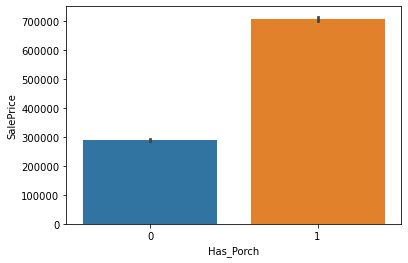

In [14]:
sns.barplot(df['Has_Porch'], df['SalePrice']);




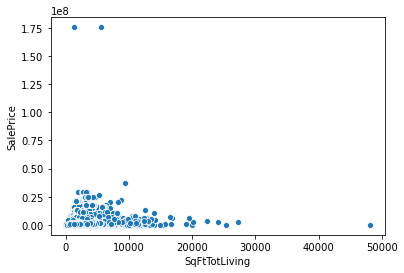

In [15]:
sns.scatterplot(df['SqFtTotLiving'], df['SalePrice']);




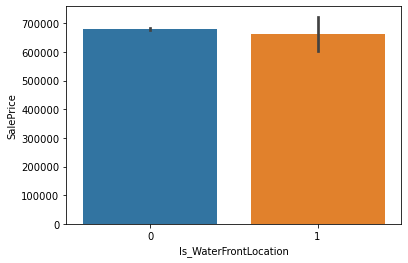

In [64]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);

In [206]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()


,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,TrafficNoise,PowerLines,OtherNuisances,Is_WaterFrontLocation,WaterFrontLocation,Has_Porch,Has_OpenPorch,Has_EnclosedPorch,NbrLivingUnits
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,0,0,0,0,None,1,1,0,1
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,0,0,0,0,None,1,1,0,1
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,0,0,0,0,None,1,1,0,1
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,0,0,0,0,None,0,0,0,1
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,1,0,0,0,None,0,0,0,1


In [207]:
#df.hist(figsize=(18,15), bins='auto');

In [217]:
df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
#df_water_dummie['SqFtTotLiving'] = df.SqFtTotLiving
df_water_dummie


,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
27723,0,0,0,0,0,0,0,0
27724,0,0,0,0,0,0,0,0
27725,0,0,0,0,0,0,0,0
27726,0,0,0,0,0,0,0,0


In [209]:
from sklearn.linear_model import LinearRegression



In [210]:
lr = LinearRegression()
lr.fit(df_water_dummie, df['SalePrice'])
#lr.__dict__


LinearRegression()

In [211]:
lr.score(df_water_dummie, df['SalePrice'])



0.39382491267103936

In [212]:
lr.coef_



array([-8.64230198e+03,  1.82451159e+06,  3.66917232e+05,  2.08094891e+06,
        3.48825330e+04,  4.17368854e+05,  4.61416527e+04,  8.82451221e+05,
        3.35148305e+02])

In [213]:
for col, coef in zip(list(df_water_dummie), lr.coef_):
    print(col,coef)


Duwamish -8642.301984721033
Lake Sammamish 1824511.5948370975
Lake Union 366917.232058954
Lake Washington 2080948.9118916402
Other lake 34882.53301025234
Puget Sound 417368.85403985356
River or slough 46141.652652212695
Ship Canal 882451.2212115147
SqFtTotLiving 335.148304847272


## Concatinate the two data frames

In [230]:
comb_df = pd.concat([df, df_water_dummie], axis=1)
comb_df.head()

,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,Has_EnclosedPorch,NbrLivingUnits,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,0
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,0,1,0,0,0,0,0,0,0,0


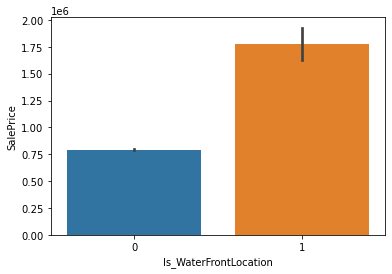

In [229]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);



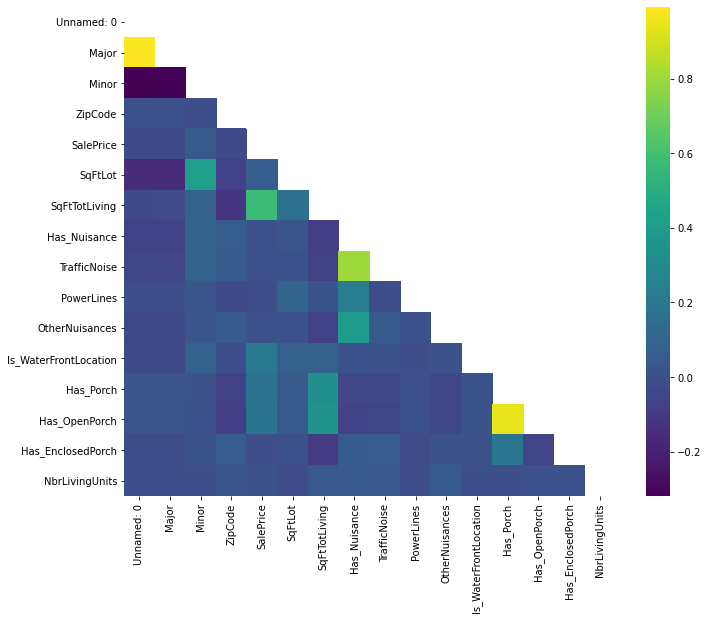

In [215]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");



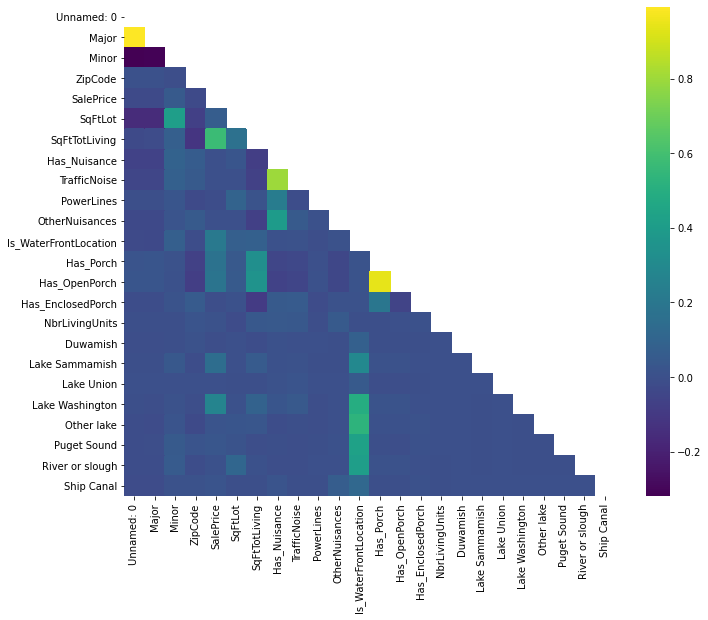

In [233]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

## EDA simple models


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

### FSM_Model 1

In [113]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving']

In [115]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.603e+04
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:04:10   Log-Likelihood:            -4.1190e+05
No. Observations:               28824   AIC:                         8.238e+05
Df Residuals:                   28822   BIC:                         8.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.106e+05   5757.098     19.217      0.000    9.93e+04    1.22e+05
SqFtTotLiving   306.1794      2.419    126.597      0.000     301.439     310.920
==============================================================================
Omnibus:                    13104.282   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110455.449
Skew:                           1.996   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                     5.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### FSM_Model 2

In [111]:
outcome = 'SalePrice'
x_cols = ['Has_Porch']

In [112]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1287.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          9.26e-276
Time:                        13:01:19   Log-Likelihood:            -4.1765e+05
No. Observations:               28824   AIC:                         8.353e+05
Df Residuals:                   28822   BIC:                         8.353e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.667e+05   4202.924    158.627      0.000    6.58e+05    6.75e+05
Has_Porch    2.02e+05   5630.090     35.873      0.000    1.91e+05    2.13e+05
==============================================================================
Omnibus:                    13917.537   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91641.326
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      10.480   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 3

In [116]:
outcome = 'SalePrice'
x_cols = ['Is_WaterFrontLocation']


In [117]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     543.6
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          3.96e-119
Time:                        13:06:08   Log-Likelihood:            -4.1801e+05
No. Observations:               28824   AIC:                         8.360e+05
Df Residuals:                   28822   BIC:                         8.360e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.713e+05   2852.292    270.404      0.000    7.66e+05    7.77e+05
Is_WaterFrontLocation  5.542e+05   2.38e+04     23.315      0.000    5.08e+05    6.01e+05
==============================================================================
Omnibus:                    13630.220   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85827.233
Skew:                           2.217   Prob(JB):                         0.00
Kurtosis:                      10.198   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 4

In [120]:
outcome = 'SalePrice'
x_cols = ['Has_Nuisance']

In [121]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Tue, 29 Sep 2020   Prob (F-statistic):              0.307
Time:                        13:09:15   Log-Likelihood:            -4.1827e+05
No. Observations:               28824   AIC:                         8.366e+05
Df Residuals:                   28822   BIC:                         8.366e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.779e+05   3137.880    247.915      0.000    7.72e+05    7.84e+05
Has_Nuisance  7765.3750   7603.559      1.021      0.307   -7137.952    2.27e+04
==============================================================================
Omnibus:                    14136.291   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92644.887
Skew:                           2.303   Prob(JB):                         0.00
Kurtosis:                      10.478   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 5

In [124]:
outcome = 'SalePrice'
x_cols = ['SqFtLot']

In [125]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           8.65e-34
Time:                        13:12:40   Log-Likelihood:            -4.1820e+05
No. Observations:               28824   AIC:                         8.364e+05
Df Residuals:                   28822   BIC:                         8.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.606e+05   3239.580    234.779      0.000    7.54e+05    7.67e+05
SqFtLot        1.4735      0.121     12.132      0.000       1.235       1.712
==============================================================================
Omnibus:                    14076.440   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92185.738
Skew:                           2.291   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     3.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Models


### ML_Model 1

In [234]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch' ]


In [236]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model1 = ols(formula=formula, data=df).fit()
ml_model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6822.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:42:35   Log-Likelihood:            -4.0289e+05
No. Observations:               27728   AIC:                         8.058e+05
Df Residuals:                   27725   BIC:                         8.058e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.764e+04   7373.289      5.105      0.000    2.32e+04    5.21e+04
SqFtTotLiving   353.4087      3.181    111.086      0.000     347.173     359.644
Has_Porch     -1.431e+04   6330.603     -2.261      0.024   -2.67e+04   -1904.546
==============================================================================
Omnibus:                    28674.977   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3431705.698
Skew:                           4.954   Prob(JB):                         0.00
Kurtosis:                      56.592   Cond. No.                     6.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 2

In [141]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation']


In [155]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model2 = ols(formula=formula, data=df).fit()
ml_model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5639.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:38:21   Log-Likelihood:            -4.1162e+05
No. Observations:               28824   AIC:                         8.232e+05
Df Residuals:                   28820   BIC:                         8.233e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.079e+05   5763.462     18.716      0.000    9.66e+04    1.19e+05
SqFtTotLiving           302.5124      2.543    118.947      0.000     297.528     307.497
Has_Porch              7563.4853   4847.244      1.560      0.119   -1937.338    1.71e+04
Is_WaterFrontLocation  4.555e+05   1.91e+04     23.894      0.000    4.18e+05    4.93e+05
==============================================================================
Omnibus:                    12545.159   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102534.109
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.422   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [242]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27728 entries, 0 to 27727
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             27728 non-null  int64 
 1   Major                  27728 non-null  int64 
 2   Minor                  27728 non-null  int64 
 3   ZipCode                27728 non-null  int64 
 4   DocumentDate           27728 non-null  object
 5   SalePrice              27728 non-null  int64 
 6   SqFtLot                27728 non-null  int64 
 7   SqFtTotLiving          27728 non-null  int64 
 8   Nuisances              27728 non-null  object
 9   Has_Nuisance           27728 non-null  int64 
 10  TrafficNoise           27728 non-null  int64 
 11  PowerLines             27728 non-null  int64 
 12  OtherNuisances         27728 non-null  int64 
 13  Is_WaterFrontLocation  27728 non-null  int64 
 14  WaterFrontLocation     27728 non-null  object
 15  Has_Porch          

In [262]:
comb_df = comb_df.rename(columns={"Other lake": "Other_lake","Lake Sammamish":"Lake_Sammamish", "Lake Union": "Lake_Union", "Lake Washington": "Lake_Washington", "Puget Sound": "Puget_Sound", "River or slough":"River_or_slough", "Ship Canal": "Ship_Canal" })

In [263]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27728 entries, 0 to 27727
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             27728 non-null  int64 
 1   Major                  27728 non-null  int64 
 2   Minor                  27728 non-null  int64 
 3   ZipCode                27728 non-null  int64 
 4   DocumentDate           27728 non-null  object
 5   SalePrice              27728 non-null  int64 
 6   SqFtLot                27728 non-null  int64 
 7   SqFtTotLiving          27728 non-null  int64 
 8   Nuisances              27728 non-null  object
 9   Has_Nuisance           27728 non-null  int64 
 10  TrafficNoise           27728 non-null  int64 
 11  PowerLines             27728 non-null  int64 
 12  OtherNuisances         27728 non-null  int64 
 13  Is_WaterFrontLocation  27728 non-null  int64 
 14  WaterFrontLocation     27728 non-null  object
 15  Has_Porch          

### ML_Model 3 --water

In [326]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Duwamish', 'Lake_Sammamish', 'Lake_Union', 'Lake_Union', 'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal']



In [327]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model3 = ols(formula=formula, data=comb_df).fit()
ml_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2001.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:02   Log-Likelihood:            -4.0150e+05
No. Observations:               27728   AIC:                         8.030e+05
Df Residuals:                   27718   BIC:                         8.031e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.663e+04   6932.048      8.169      0.000     4.3e+04    7.02e+04
SqFtTotLiving     335.1483      2.877    116.486      0.000     329.509     340.788
Duwamish        -8642.3020   2.72e+05     -0.032      0.975   -5.41e+05    5.24e+05
Lake_Sammamish   1.825e+06   7.36e+04     24.787      0.000    1.68e+06    1.97e+06
Lake_Union       3.669e+05    4.7e+05      0.780      0.435   -5.55e+05    1.29e+06
Lake_Washington  2.081e+06   4.39e+04     47.360      0.000    1.99e+06    2.17e+06
Other_lake       3.488e+04   4.09e+04      0.853      0.394   -4.53e+04    1.15e+05
Puget_Sound      4.174e+05   4.97e+04      8.405      0.000     3.2e+05    5.15e+05
River_or_slough  4.614e+04   5.27e+04      0.876      0.381   -5.71e+04    1.49e+05
Ship_Canal       8.825e+05   1.78e+05      4.964      0.000    5.34e+05    1.23e+06
==============================================================================
Omnibus:                    26453.788   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3114673.024
Skew:                           4.295   Prob(JB):                         0.00
Kurtosis:                      54.206   Cond. No.                     4.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ML_Model4 -- Nuisance

In [328]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','TrafficNoise', 'PowerLines']


In [329]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model4 = ols(formula=formula, data=comb_df).fit()
ml_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4591.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:51   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27724   BIC:                         8.057e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.348e+04   7416.255      3.167      0.002    8948.641     3.8e+04
SqFtTotLiving   352.9423      3.008    117.320      0.000     347.046     358.839
TrafficNoise   4.314e+04   5353.512      8.059      0.000    3.27e+04    5.36e+04
PowerLines    -1.475e+05    2.9e+04     -5.094      0.000   -2.04e+05   -9.07e+04
==============================================================================
Omnibus:                    28736.048   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3490612.831
Skew:                           4.967   Prob(JB):                         0.00
Kurtosis:                      57.061   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 5 --Porch 

In [330]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Has_OpenPorch','Has_EnclosedPorch']


In [331]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model5 = ols(formula=formula, data=comb_df).fit()
ml_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4591.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:37:05   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27724   BIC:                         8.057e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.793e+04   7419.216      3.765      0.000    1.34e+04    4.25e+04
SqFtTotLiving       358.2657      3.220    111.246      0.000     351.953     364.578
Has_OpenPorch     -2.734e+04   6359.046     -4.300      0.000   -3.98e+04   -1.49e+04
Has_EnclosedPorch  1.192e+05   1.41e+04      8.421      0.000    9.14e+04    1.47e+05
==============================================================================
Omnibus:                    28710.064   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3466978.989
Skew:                           4.961   Prob(JB):                         0.00
Kurtosis:                      56.874   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 6 --Zip Code

In [332]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','ZipCode']

In [333]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model6 = ols(formula=formula, data=comb_df).fit()
ml_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     6877.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:37:15   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27725   BIC:                         8.057e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.651e+07   2.98e+06     -8.912      0.000   -3.23e+07   -2.07e+07
SqFtTotLiving   354.1703      3.022    117.189      0.000     348.247     360.094
ZipCode         270.6155     30.326      8.923      0.000     211.174     330.057
==============================================================================
Omnibus:                    28802.752   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3492031.902
Skew:                           4.989   Prob(JB):                         0.00
Kurtosis:                      57.065   Cond. No.                     9.84e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 7 --All together

In [334]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Duwamish', 'Lake_Sammamish', 'Lake_Union', 
          'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal',
         'TrafficNoise', 'PowerLines','Has_OpenPorch', 'Has_EnclosedPorch', 'ZipCode']



In [335]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model7 = ols(formula=formula, data=comb_df).fit()
ml_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     1310.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:37:25   Log-Likelihood:            -4.0139e+05
No. Observations:               27728   AIC:                         8.028e+05
Df Residuals:                   27713   BIC:                         8.029e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.397e+07   2.83e+06     -8.463      0.000   -2.95e+07   -1.84e+07
SqFtTotLiving       344.6337      3.092    111.462      0.000     338.573     350.694
Duwamish            -2.6e+04   2.71e+05     -0.096      0.923   -5.56e+05    5.04e+05
Lake_Sammamish     1.819e+06   7.34e+04     24.794      0.000    1.67e+06    1.96e+06
Lake_Union         3.105e+05   4.69e+05      0.663      0.508   -6.08e+05    1.23e+06
Lake_Washington    2.062e+06   4.38e+04     47.029      0.000    1.98e+06    2.15e+06
Other_lake         3.563e+04   4.08e+04      0.874      0.382   -4.43e+04    1.16e+05
Puget_Sound        4.077e+05   4.95e+04      8.238      0.000    3.11e+05    5.05e+05
River_or_slough    5.417e+04   5.25e+04      1.032      0.302   -4.87e+04    1.57e+05
Ship_Canal         8.605e+05   1.77e+05      4.858      0.000    5.13e+05    1.21e+06
TrafficNoise       2.672e+04   5099.647      5.239      0.000    1.67e+04    3.67e+04
PowerLines        -1.234e+05   2.75e+04     -4.490      0.000   -1.77e+05   -6.96e+04
Has_OpenPorch     -1.874e+04   6043.975     -3.101      0.002   -3.06e+04   -6892.958
Has_EnclosedPorch  1.011e+05   1.35e+04      7.514      0.000    7.47e+04    1.28e+05
ZipCode             244.8024     28.876      8.478      0.000     188.204     301.401
==============================================================================
Omnibus:                    26596.573   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3239395.943
Skew:                           4.323   Prob(JB):                         0.00
Kurtosis:                      55.241   Cond. No.                     9.88e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multicollinearity check

In [293]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [310]:
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('SqFtTotLiving', 7.00191735511102),
 ('Duwamish', 1.0002586674309506),
 ('Lake_Sammamish', 1.0046737749616623),
 ('Lake_Union', 1.0004528386526075),
 ('Lake_Washington', 1.0152451658242738),
 ('Other_lake', 1.006369496966257),
 ('Puget_Sound', 1.0035581741099688),
 ('River_or_slough', 1.0031092087251676),
 ('Ship_Canal', 1.0003715423719974),
 ('TrafficNoise', 1.1447202035849442),
 ('PowerLines', 1.0116932644751637),
 ('Has_OpenPorch', 2.4517619366163212),
 ('Has_EnclosedPorch', 1.0608801760021849),
 ('ZipCode', 6.559849510451755)]

In [296]:
#looking for under 5 vif?

In [311]:
#testing with Rainbow test

rainbow_statistic, rainbow_p_value = linear_rainbow(ml_model7)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0116305571739665
Rainbow p-value: 0.24806804130205018


# Normality Check/Q-Q plot


In [299]:
import statsmodels.api as sm
import scipy.stats as stats

dist=stats.norm
fit=True

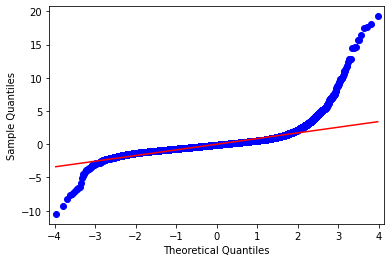

In [317]:
fig = sm.graphics.qqplot(ml_model7.resid, line='r',dist=stats.norm, fit=True)

# Homoscedasticity Check

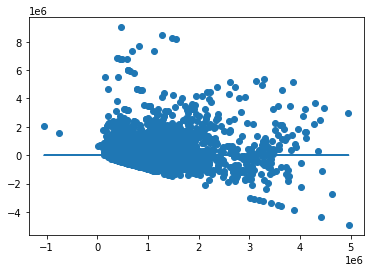

In [318]:
plt.scatter(ml_model7.predict(comb_df[x_cols]), ml_model7.resid)
plt.plot(ml_model7.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);